In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
device= "cpu"

In [5]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)

In [6]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4066, -0.4257],
                      [-0.0726,  0.0698],
                      [ 0.4104,  0.3404],
                      [-0.1198,  0.3742],
                      [-0.1900,  0.1606],
                      [ 0.6923, -0.4851],
                      [-0.0876, -0.1364],
                      [ 0.6661, -0.2197],
                      [-0.1240, -0.6091],
                      [ 0.2418,  0.4173]])),
             ('0.bias',
              tensor([ 0.6911, -0.5856, -0.0147,  0.7010,  0.3060,  0.3143,  0.4103,  0.0163,
                       0.1263, -0.6981])),
             ('1.weight',
              tensor([[-0.0275,  0.2445, -0.2342, -0.1967,  0.2921, -0.2880,  0.3096,  0.1832,
                        0.1505,  0.2230]])),
             ('1.bias', tensor([0.2481]))])

In [7]:
from sklearn import datasets
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2549, -0.6126],
                      [-0.6582,  0.1603],
                      [ 0.0107, -0.3774],
                      [ 0.6878, -0.2549],
                      [ 0.1064,  0.5937]])),
             ('layer_1.bias',
              tensor([-0.2351, -0.6536,  0.0322,  0.4266,  0.1639])),
             ('layer_2.weight',
              tensor([[-0.0176, -0.1183,  0.1256, -0.1938,  0.0361]])),
             ('layer_2.bias', tensor([0.3779]))])

In [9]:
import sklearn
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)
len(X), len(y)

(1000, 1000)

In [10]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


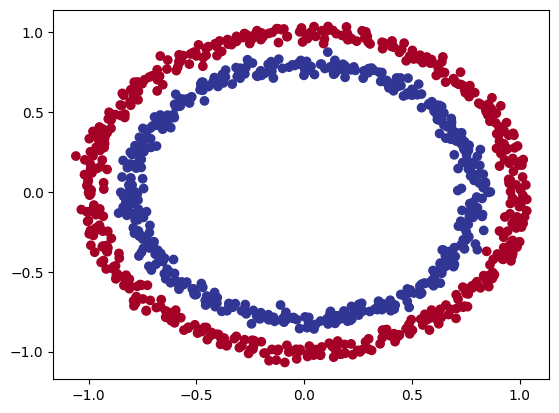

In [11]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [12]:
X_sample = X[0]
y_sample = y[0]
print(f"values for one sample of X: {X_sample}")
print(f"values for one sample of y: {y_sample}")
print(f"shape for one sample of X: {X_sample.shape}")
print(f"shape for one sample of y: {y_sample.shape}")

values for one sample of X: [0.75424625 0.23148074]
values for one sample of y: 1
shape for one sample of X: (2,)
shape for one sample of y: ()


In [13]:
import torch
torch.__version__

'2.8.0'

In [14]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [15]:
torch.manual_seed(42) # only works in torch, doesn't affect scikitlearn

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [17]:
# Predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
untrained_preds[:10]

tensor([[0.4175],
        [0.4004],
        [0.4203],
        [0.4170],
        [0.3532],
        [0.3432],
        [0.3481],
        [0.3345],
        [0.4231],
        [0.3985]])

classification neural network
## 2.1 Setup losss function and optimizer

Which loss function or optimizer should you use?

Again... it is problem specific

For example for regression you might want MAE or MSE

For classficiation you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, loss function measures how wrong the function

For optimizers, two most common and useful are SGD and Adam, however PyTorch has many

In DL, logits layer means the layer that feeds in to softmax (or such normalization).

For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`

In [18]:
# Setup the loss function
# loss_fn = nn.BCELoss()  Requires inputs to have gone through the sigmoid activation function prior to input to BCELoss 
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in
# more stable than using plain nn.Sequential(nn.Sigmoid(), nn.BCELoss())

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)


In [19]:
# Calculate accuracy = True Positive/(True Positive + True Negative) * 100
                    # out of 100 exmaples, what percentage does our model get right

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc





## 3. Train Model
Need: Training loop
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer (gradient descent)

### 3. 1Going from raw logits -> prediction probabilities -> prediciton labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert out model's prediciton probabilities to **prediction labels** by rounding them (binary) or taking the argmax().

In [ ]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits # raw outputs of model

tensor([[0.4175],
        [0.4004],
        [0.4203],
        [0.4170],
        [0.3532]])

In [23]:
# Use sigmoid activation on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6029],
        [0.5988],
        [0.6035],
        [0.6028],
        [0.5874]])

In [25]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [22]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

From our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, y=1 (class 1)
* `y_pred_probs` <> 0.5, y=0 (class 0)

In [ ]:
# Find predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check equality
print(torch.eq(y_preds.squeeze(dim=1), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building training test loop

In [29]:
device

'cpu'

In [34]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Build training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    
    # 2. Calculuate loss/accuracy
    loss = loss_fn(y_logits, # nn.BCE WithLogitsLoss expects raw logits as input
                    y_train)

    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # print out what's happening
        if epoch%10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.2f} | Test accuracy: {test_acc: .2f}")




Epoch: 0 | Loss: 0.69397, Acc: 50.88% | Test loss: 0.69 | Test accuracy:  50.50
Epoch: 10 | Loss: 0.69388, Acc: 50.50% | Test loss: 0.69 | Test accuracy:  51.00
Epoch: 20 | Loss: 0.69379, Acc: 50.50% | Test loss: 0.69 | Test accuracy:  50.50
Epoch: 30 | Loss: 0.69372, Acc: 50.50% | Test loss: 0.69 | Test accuracy:  50.50
Epoch: 40 | Loss: 0.69365, Acc: 50.38% | Test loss: 0.69 | Test accuracy:  51.50
Epoch: 50 | Loss: 0.69359, Acc: 50.50% | Test loss: 0.69 | Test accuracy:  52.50
Epoch: 60 | Loss: 0.69353, Acc: 50.88% | Test loss: 0.69 | Test accuracy:  53.00
Epoch: 70 | Loss: 0.69348, Acc: 50.25% | Test loss: 0.69 | Test accuracy:  52.50
Epoch: 80 | Loss: 0.69344, Acc: 50.00% | Test loss: 0.69 | Test accuracy:  53.50
Epoch: 90 | Loss: 0.69340, Acc: 50.12% | Test loss: 0.69 | Test accuracy:  53.50


### Need to visualize what we created

In [38]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

download helper_functions.py


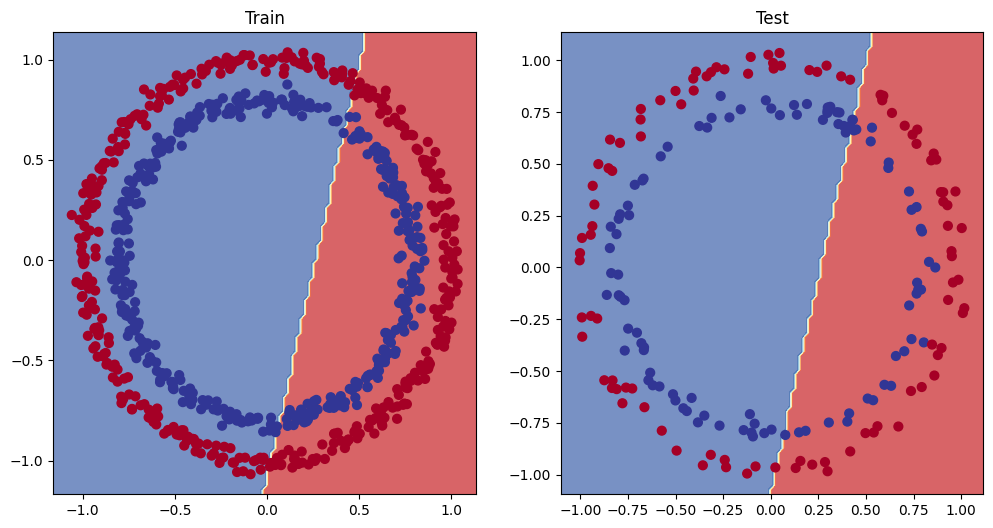

In [40]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# CH4 Custom Datasets

1. Want to load images from file
2. Want to get class names from Dataset
3. Want to get classes as dicrionary from the datasaets

Pros: 
* Can create a `Dataset` out of almost everything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* even though you could create `Dataset` out of almost anything, it doens't mean it will work
* Using a `Dataset` often results in us writing more code, which could be prone to errors or perofrmance issues

In [41]:
import os 
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [45]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" 

if image_path.is_dir():
    print(f"{image_path} directory already exists...skipping download")
    image_path.mkdir(parents=True, exist_ok=True)
else:
    print(f"{image_path} does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downdnloading pizza/steak/sushi data")
    f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...skipping download
Downdnloading pizza/steak/sushi data
Unzipping pizza, steak, sushi data


In [46]:
image_path

PosixPath('data/pizza_steak_sushi')

In [54]:
## 2. Becoming one with the data (prep and exploration)
import os
def walk_through_dir(dir_path):
    """Walks throguh dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [55]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [ ]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test" 


In [48]:
# Instance of torcvision.datasets. ImageFolder()
train_data.classes, train_data.class_to_idx

NameError: name 'train_data' is not defined